### Step 2: Verify Runze's method
1. Read Runze's test data to get the MR and CBCT 
2. Deform before resize, using the same parameters as Runze and the same code
3. Visualize

In [4]:
from layers import VecInt
from scipy.ndimage import distance_transform_edt as bwdist

class SourceWarpPoint:
    def __init__(self, point, decay_power=1, deformation_magnitude=6):

        # Default values
        self.decay_power = decay_power
        self.deformation_magnitude = deformation_magnitude
        self.point = point

    def print(self):
        print('point: ', self.point, ' decay power: ', self.decay_power,
              ' deformation magnitude: ', self.deformation_magnitude)


class SourceGen:
    """
    Randomly generate source points with:
    n_points: number of source points to drive deformation
    random decay power: min and max value
    deformation magnitude: min and max value
    Source points are randomly located with a given mask (e.g ventricle)
    """
    def __init__(self, n_points, image_shape, decay_power_range=[0.5, 2], deformation_magnitude_range=[1, 5]):
        self.image_shape = image_shape
        self.decay_power_range = decay_power_range
        self.deformation_magnitude_range = deformation_magnitude_range
        self.n_points = n_points

    def run(self, ventricle_mask=None):
        points = []
        sources = []

        if ventricle_mask is None:
            x, y, z = np.meshgrid(np.linspace(0, self.image_shape[0]-1, self.image_shape[0]),
                                  np.linspace(0, self.image_shape[1]-1, self.image_shape[1]),
                                  np.linspace(0, self.image_shape[2]-1, self.image_shape[2]))
        else:
            islice = np.argmax(np.sum(ventricle_mask > 0, axis=(0, 1)))  # find the slice with the largest masked volume
            mask_center = np.zeros(ventricle_mask.shape)
            mask_center[:, :, islice-5:islice+4] = ventricle_mask[:, :, islice - 5:islice + 4]  # only place sources around ±5 slices from islice
            x, y, z = np.where(mask_center > 0)
            loc = np.where(z == islice)
            # nloc = [loc[0][0],loc[0][-1]]

        index = np.random.randint(len(x), size=self.n_points)
        for i in range(self.n_points):
            # points.append([x[nloc[0]], y[nloc[0]], islice])
            points.append([x[index[i]], y[index[i]], z[index[i]]])
            # np.random.seed(123)
            alpha = np.random.uniform(low=self.deformation_magnitude_range[0], high=self.deformation_magnitude_range[1])
            beta_exp = np.random.uniform(low=np.log(self.decay_power_range[0]),
                                         high=np.log(np.minimum(self.decay_power_range[1], np.log2(alpha/(alpha-1)))))
            beta = np.exp(beta_exp)

            sources.append(SourceWarpPoint(point=points[i], decay_power=beta,
                                           deformation_magnitude=alpha*np.random.choice([-1, 1])))
        return sources


class Simulator:
    """
    Simulate a random deformation field based on source model D=a/r^b from multiple source points.

    Returns
    -------
    D : the overall deformation field

    """

    def __init__(self, image_size=[192, 240, 192], int_steps=2,unit = False):

        self._image_size = image_size
        # self.transformer = SpatialTransformer(image_size, mode=interp_method)
        self.vectint = VecInt(image_size, int_steps)  # square and scaling layer for exponentiation
        self.unit = unit

    def simulate(self, sources, brain_mask=None, thresh=30):
        """
        sources: sources to drive deformation, generated from SourceGen
        brain_mask: optional mask of the brain region, deformation outside is set to 0
        thresh: a threshold of the distance to the brain boundary (value above thresh is not affected)
        """
        [X, Y, Z] = np.mgrid[0:self._image_size[0], 0:self._image_size[1], 0:self._image_size[2]]
        D = np.zeros((3, self._image_size[0], self._image_size[1], self._image_size[2]))
        
        for source in sources:
            decay_power = source.decay_power
            deformation_mag = source.deformation_magnitude
        
            if self.unit:
                R2 = np.square((X-source.point[0])*1.5/0.7) + np.square((Y-source.point[1])*1.5/0.7) + np.square((Z-source.point[2])*1.5)
            else:
                R2 = np.square((X-source.point[0])) + np.square((Y-source.point[1])) + np.square((Z-source.point[2]))
            # dist = R2
            # R2 = (R2-R2.min())/(R2.max()-R2.min())
            # F = deformation_mag*(1-R2)**decay_power


            # DX = (X-source.point[0])/(np.sqrt(dist)+1e-5)*F
            # DY = (Y-source.point[1])/(np.sqrt(dist)+1e-5)*F
            # DZ = (Z-source.point[2])/(np.sqrt(dist)+1e-5)*F
            
            # DX[source.point[0],source.point[1],source.point[2]] = (DX[source.point[0]+1,source.point[1],source.point[2]]+DX[source.point[0]-1,source.point[1],source.point[2]])/2
            # DY[source.point[0],source.point[1],source.point[2]] = (DY[source.point[0],source.point[1]+1,source.point[2]]+DX[source.point[0],source.point[1]-1,source.point[2]])/2
            # DZ[source.point[0],source.point[1],source.point[2]] = (DZ[source.point[0],source.point[1],source.point[2]+1]+DX[source.point[0],source.point[1],source.point[2]-1])/2
            
            # DX = F
            # DY = F
            # DZ = F
            F = deformation_mag/(np.power(R2, decay_power/2)+1e-6) # deformation magnitude (+retraction,-dilation)
            F[source.point[0], source.point[1], source.point[2]] = deformation_mag

            DX = (X-source.point[0])/(np.sqrt(R2)+1e-5)*F
            DY = (Y-source.point[1])/(np.sqrt(R2)+1e-5)*F
            DZ = (Z-source.point[2])/(np.sqrt(R2)+1e-5)*F
            

            D = D + np.stack((DX, DY, DZ), axis=0)
            

        if brain_mask is not None:  # set deformation outside the brain to 0 with smooth transitions
            brain_dist = bwdist(brain_mask) / 30
            brain_dist[brain_dist > 1] = 1
            D = np.multiply(D, np.repeat(brain_dist[np.newaxis, :, :], 3, axis=0))


        D = self.vectint(torch.from_numpy(D).unsqueeze(0).float())
        
        return D #torch.from_numpy(D).unsqueeze(0).float()
    



### Loading Runze's data
The data ISN'T resized to 128x160x128

In [5]:
import nibabel as nib
import torch
import numpy as np
import pandas as pd
from dataloader import RadOncTrainingDataset, RadOncValidationDataset, RadOncSynthesisDataset, headscanner_training_dataset, headscanner_validation_dataset
import matplotlib.pyplot as plt
from skimage.transform import resize

# test_path_r = "/mnt/blackhole-data2/RadOnc_Brain/NonRigid_Training_CBCT"
test_path_r = "/mnt/blackhole-data2/RadOnc_Brain/Validation"
mr_list = []
ct_list = []
cbct_list = []
mask_list = []
mask_brain_list = []
flow_list = []
for i in range(10):
    name = f'/{i:03}.npz'
    data = np.load(test_path_r+name)
    # cbct_list.append(resize(data['cbct'], [128,160,128], order=0, anti_aliasing=False))
    # mr_list.append(resize(data['moving_truth'], [128,160,128], order=0, anti_aliasing=False))
    # ct_list.append(resize(data['fixed_img'], [128,160,128], order=0, anti_aliasing=False))
    # mask_list.append(resize(data['ventricle_fixed'], [128,160,128], order=0, anti_aliasing=False))
    # mask_brain_list.append((ct_list[-1]>0).astype(int))
    # flow_list.append(data['flow'])
    
    cbct_list.append(data['cbct'])
    mr_list.append(data['moving_truth'])
    ct_list.append(data['fixed_img'])
    mask_list.append(data['ventricle_fixed'])
    mask_brain_list.append((ct_list[-1]>0).astype(int))
    flow_list.append(data['flow'])
    


In [29]:
print(ct_list[0].shape,cbct_list[0].shape,mr_list[0].shape,mask_list[0].shape,mask_brain_list[0].shape)
print(mr_list[0].max(),mr_list[0].min())

(128, 160, 128) (128, 160, 128) (128, 160, 128) (128, 160, 128) (128, 160, 128)
0.8150173265107196 0.021560245250248446


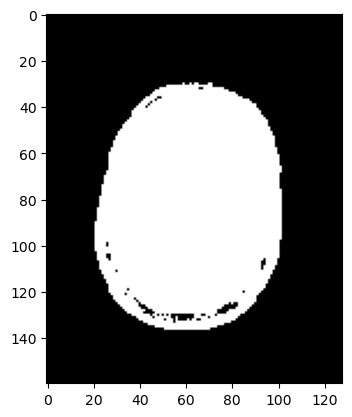

In [5]:
import matplotlib.pyplot as plt
plt.imshow(mask_brain_list[0][:,:,96].T,cmap = 'gray')

In [30]:
type(flow_list[0])

numpy.ndarray

In [35]:
for i,flow in enumerate(mr_list):
    torch.save(flow,'/home/myi16/jsr_Y/sample data/Runze/'+'mr'+f'{i:03}.pt')
    # dist = ((flow[0,:,:,:,0]*0.7)**2+(flow[0,:,:,:,1]*0.7)**2+flow[0,:,:,:,2]**2)**0.5
    # fig,ax = plt.subplots(1,1,figsize = (12,8))
    # ax.imshow(dist[:,:,100].T,cmap = 'hot')

### Deformation
$\alpha:U[2,5]$
$\beta:U[5e^{-3},3e^{-2}]$
(All same with Runze's settings)


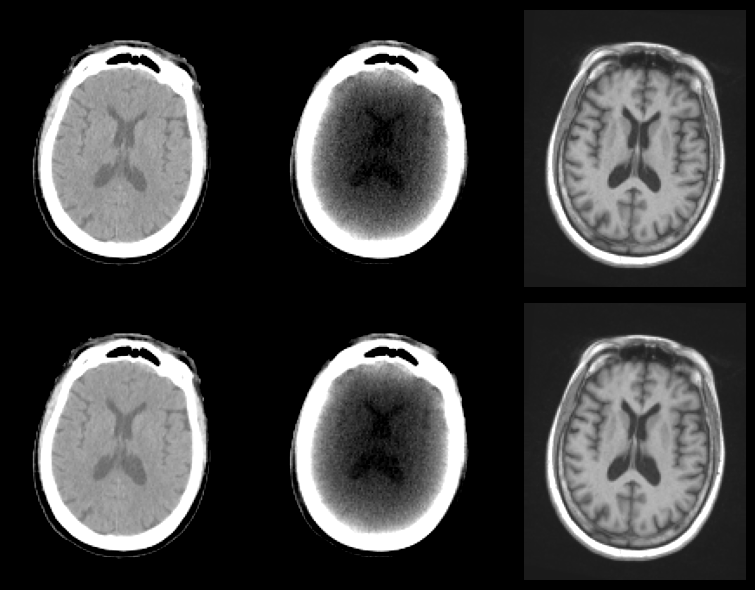

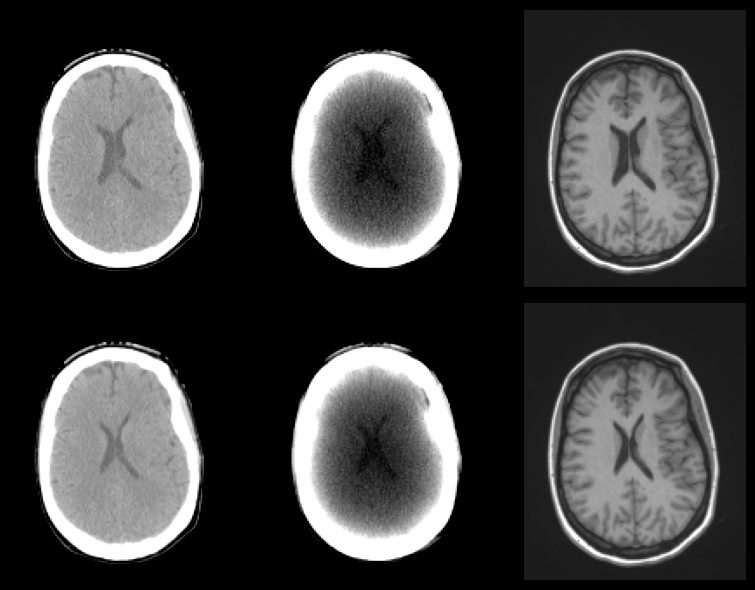

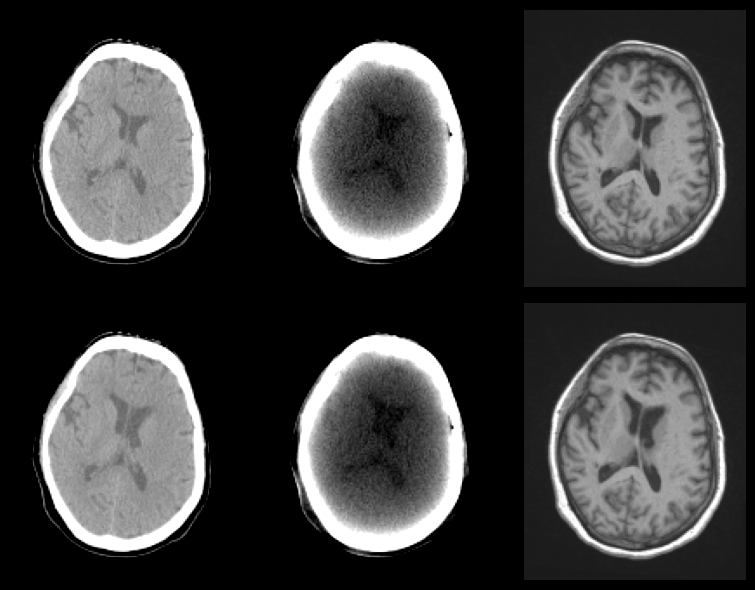

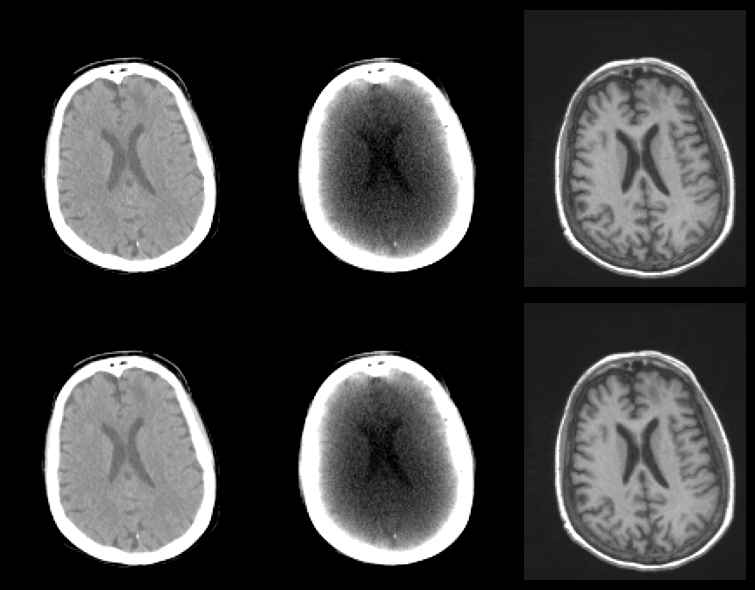

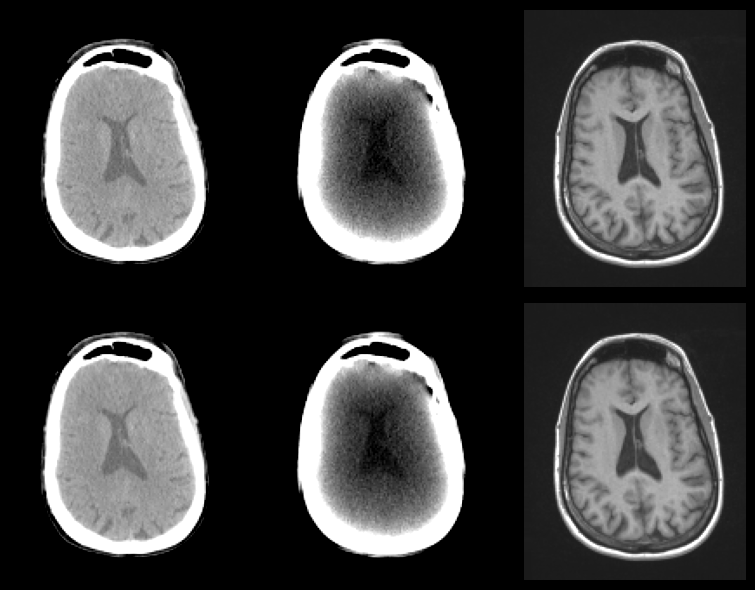

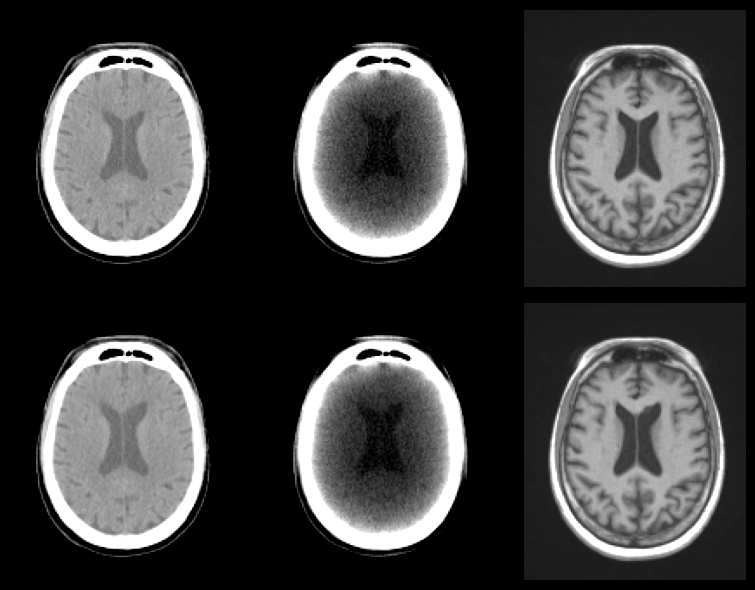

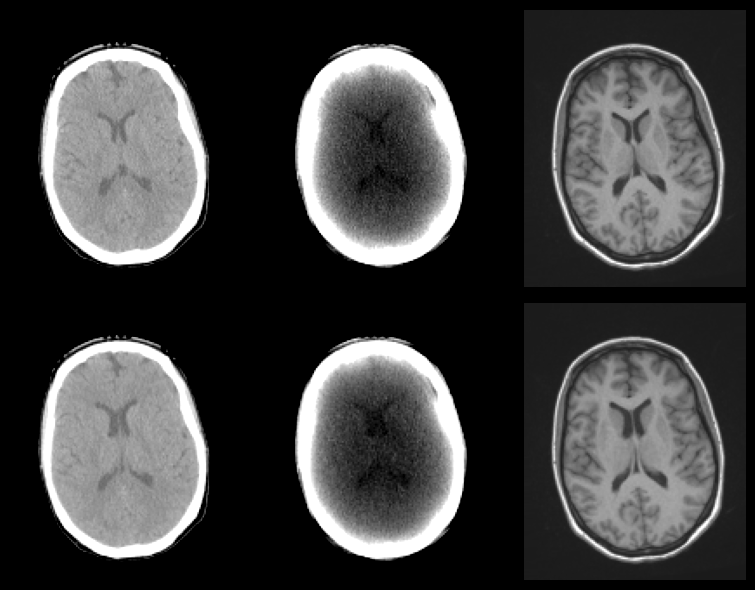

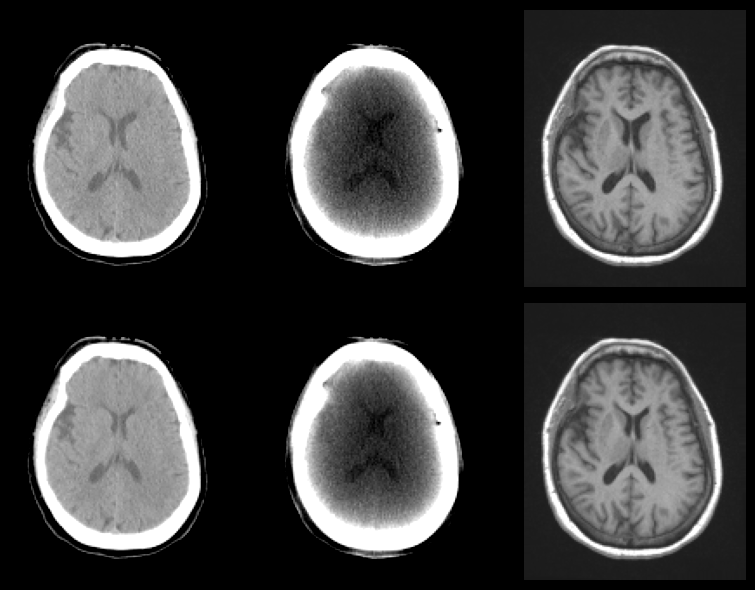

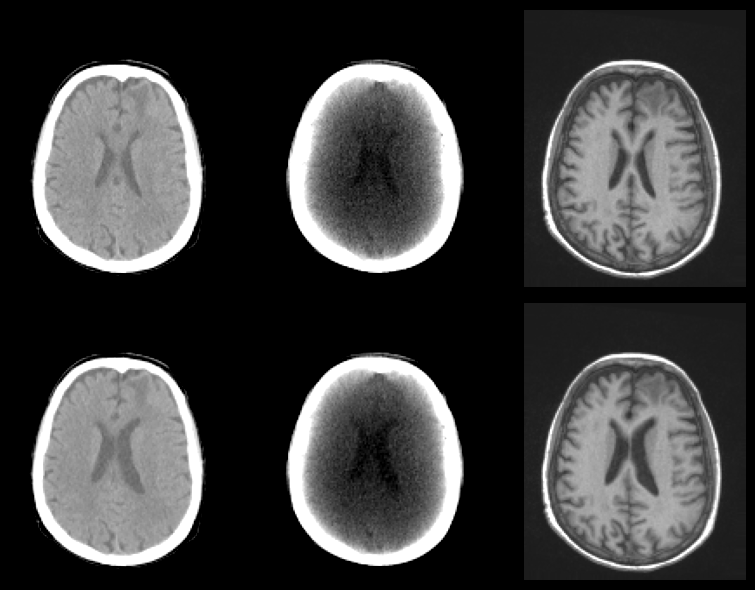

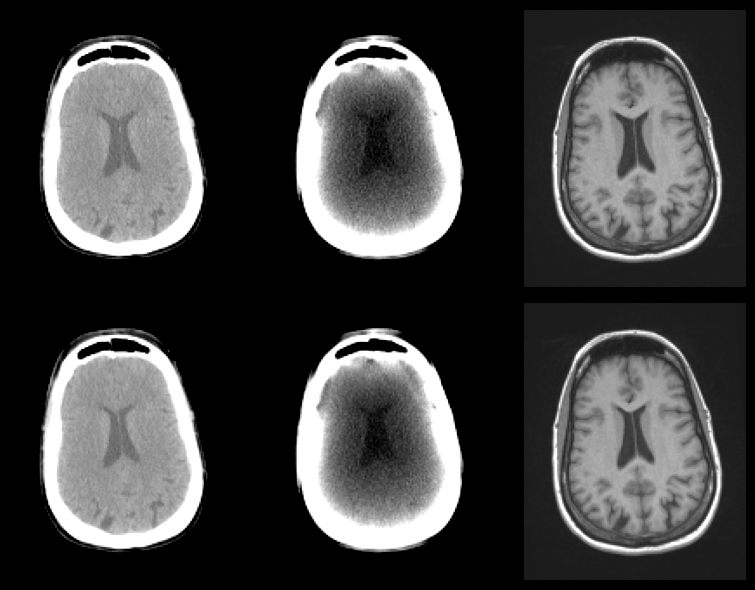

In [62]:
from layers import SpatialTransformer
from scipy.ndimage.interpolation import affine_transform
from helpers import normalizeImage, random_transform


config = dict()
config['image_size'] = [128, 160, 128]
config['augment_translation'] = 5
config['augment_rotation'] = 5
config['augment_n_points'] = [1, 5]  # number of points in deformation simulation
config['augment_decay_power_range'] = [0.1, 0.5]  # [1e-2,1e-1] # decay power range in deformation simulation
config['augment_deformation_range'] = [3, 5]  # deformation magnitude range in deformation simulation

# original_shape = config['image_size']
# transformer_linear = SpatialTransformer(original_shape, mode='bilinear')
# transformer_nearest = SpatialTransformer(original_shape, mode='nearest')

mr_input = []
mr_gt = []
cbct_input = []
mask_input = []
mask_gt = []
ct_input = []
ct_gt = []

for index in range(10):
    original_shape = mr_list[index].shape
    transformer_linear = SpatialTransformer(original_shape, mode='bilinear')
    transformer_nearest = SpatialTransformer(original_shape, mode='nearest') 
    ct = ct_list[index]
    mr = mr_list[index]
    cbct = cbct_list[index]
    mask_ventricle = mask_list[index]
    mask_brain = mask_brain_list[index]
    
    T = random_transform(list(np.shape(mr)), config['augment_translation'], config['augment_rotation'])
    ct = affine_transform(ct, T, mode='nearest')
    mr = affine_transform(mr, T, mode='nearest')
    cbct = affine_transform(cbct, T, mode='nearest')
    mask_ventricle = affine_transform(mask_ventricle, T, mode='nearest', order=0)
    mask_brain = affine_transform(mask_brain, T, mode='nearest', order=0)

    # Simulate deformations
    n_points = np.random.randint(config['augment_n_points'][0], config['augment_n_points'][1])
    source_gen = SourceGen(n_points, original_shape, decay_power_range=config['augment_decay_power_range'],
                           deformation_magnitude_range=config['augment_deformation_range'])
    sources = source_gen.run(ventricle_mask=(mask_ventricle == 23) + (mask_ventricle == 24))
    sim = Simulator(original_shape)
    flow = sim.simulate(sources, mask_brain)

    # Apply deformations
    
    ct = torch.from_numpy(ct).unsqueeze(0).unsqueeze(0).float()
    ct_deform = transformer_linear(ct, flow)
    mr = torch.from_numpy(mr).unsqueeze(0).unsqueeze(0).float()
    mr_deform = transformer_linear(mr, flow)
    cbct = torch.from_numpy(cbct).unsqueeze(0).unsqueeze(0).float()
    cbct_deform = transformer_linear(cbct, flow)
    mask = torch.from_numpy(mask_ventricle).unsqueeze(0).unsqueeze(0).float()
    mask_deform = transformer_nearest(mask, flow)
    
    mr = resize(mr.squeeze().numpy(), config['image_size'], order=3)
    mr_deform = resize(mr_deform.squeeze().numpy(), config['image_size'], order=3)

    ct = resize(ct.squeeze().numpy(), config['image_size'], order=3)
    ct_deform = resize(ct_deform.squeeze().numpy(), config['image_size'], order=3)
    cbct = resize(cbct.squeeze().numpy(), config['image_size'], order=3)
    cbct_deform = resize(cbct_deform.squeeze().numpy(), config['image_size'], order=3)

    mask = resize(mask.squeeze().numpy(), config['image_size'], order=0, anti_aliasing=False).astype(np.int8)
    mask_deform = resize(mask_deform.squeeze().numpy(), config['image_size'], order=0, anti_aliasing=False).astype(np.int8)

    mr_input.append(mr_deform)
    mr_gt.append(mr)
    cbct_input.append(cbct)
    ct_input.append(ct_deform)
    ct_gt.append(ct)
    mask_input.append(mask_deform)
    mask_gt.append(mask)
    
    # islice = 70
    # fig, ax = plt.subplots(2,3,figsize=(8,6))
    # np.vectorize(lambda ax: ax.axis('off'))(ax)
    # ax[0, 0].imshow(ct[0,0,:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
    # ax[1, 0].imshow(ct_deform[0,0,:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
    # ax[0, 1].imshow(cbct[0,0,:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
    # ax[1, 1].imshow(cbct_deform[0,0,:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
    # ax[0, 2].imshow(mr[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
    # ax[1, 2].imshow(mr_deform[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
    # plt.tight_layout()
    # plt.show()
    
    islice = 70
    fig, ax = plt.subplots(2,3,figsize=(8,6))
    np.vectorize(lambda ax: ax.axis('off'))(ax)
    ax[0, 0].imshow(ct[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
    ax[1, 0].imshow(ct_deform[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
    ax[0, 1].imshow(cbct[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
    ax[1, 1].imshow(cbct_deform[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
    ax[0, 2].imshow(mr[:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
    ax[1, 2].imshow(mr_deform[:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
    plt.tight_layout()
    plt.show()


    

In [63]:
import networks_gan
device = 'cpu'
G = networks_gan.JSRCascade(separate_decoders=True, res=True, version='v3').to(device)
checkpoint = torch.load('JSRCascade_l1100_multi0.3_reg100_seg0_ep109.pt', map_location=torch.device('cpu'))
G.load_state_dict(checkpoint['G_state_dict'])

<All keys matched successfully>

In [18]:
seg_fixed.shape

torch.Size([128, 160, 128])

### Test Runze's Checkpoint

  0%|          | 0/10 [00:00<?, ?it/s]

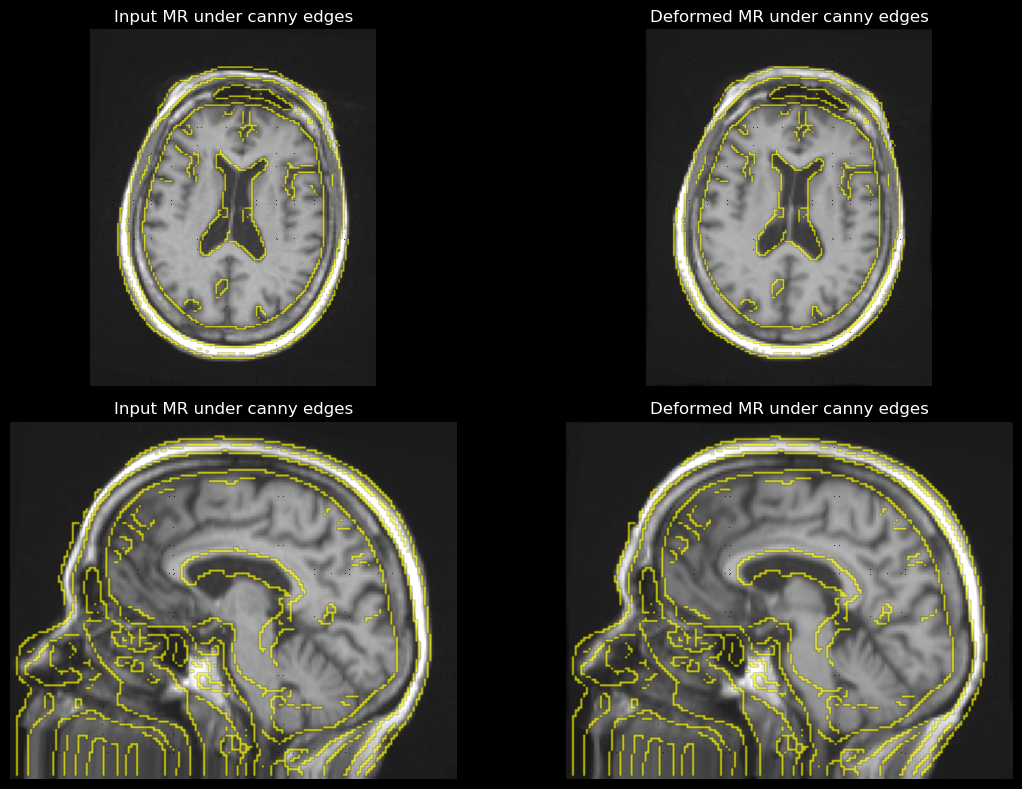

 10%|█         | 1/10 [00:10<01:33, 10.41s/it]

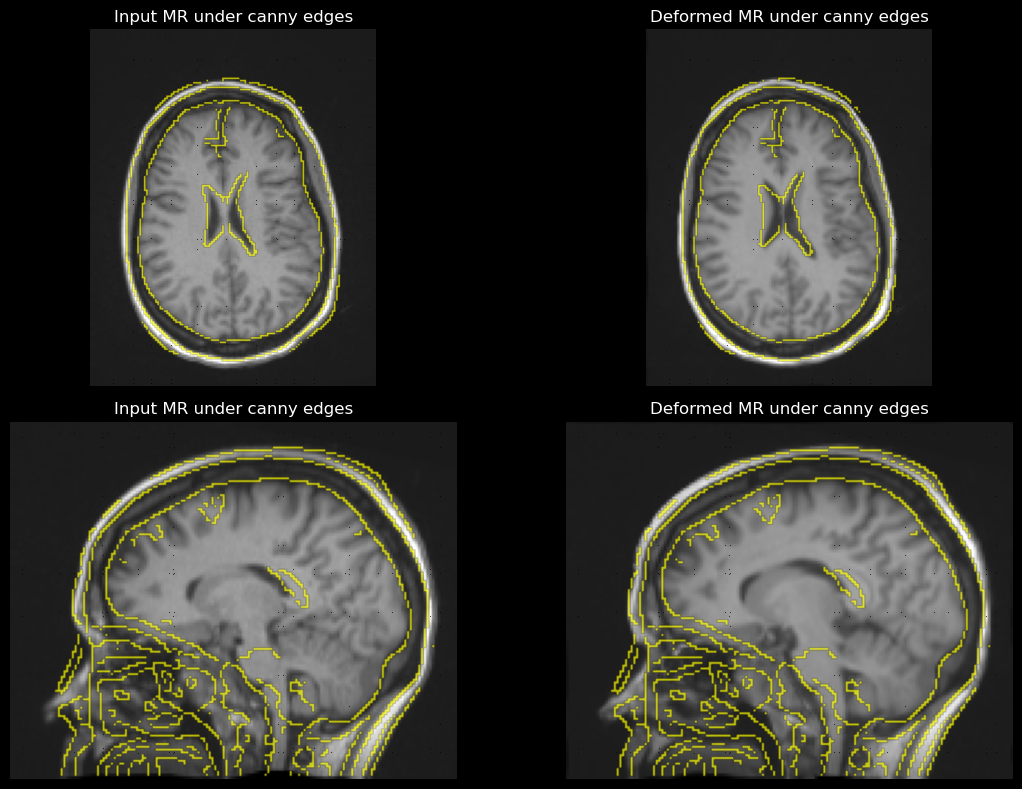

 20%|██        | 2/10 [00:21<01:24, 10.53s/it]

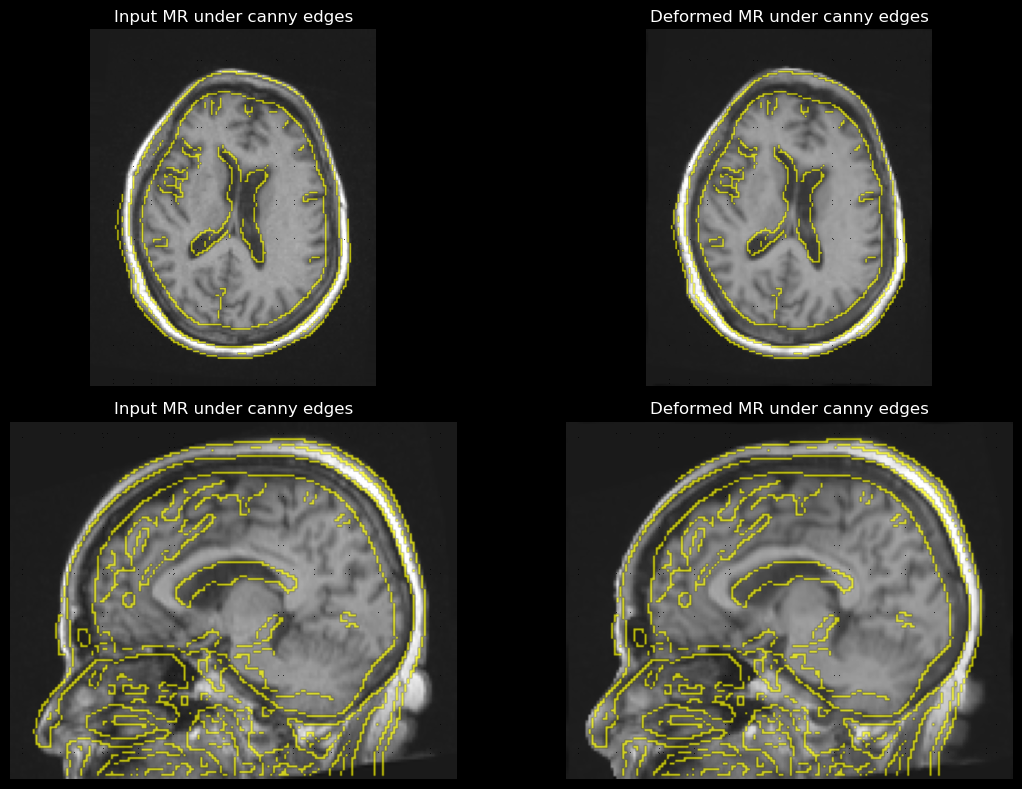

 30%|███       | 3/10 [00:31<01:14, 10.59s/it]

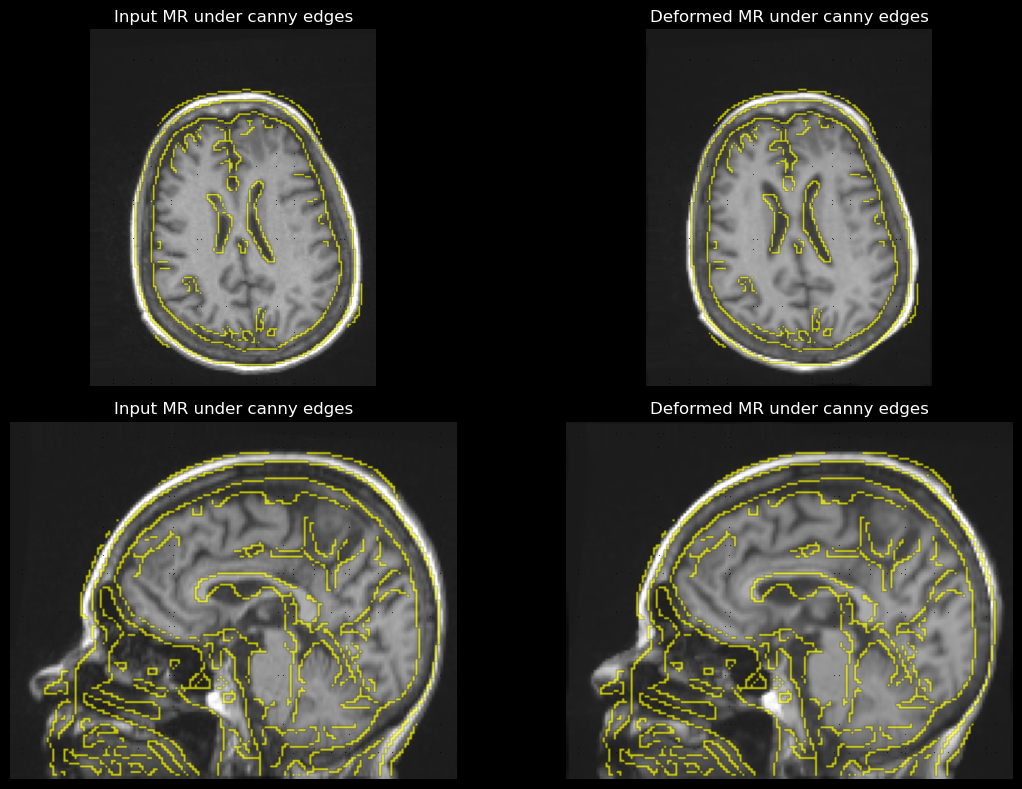

 40%|████      | 4/10 [00:42<01:02, 10.50s/it]

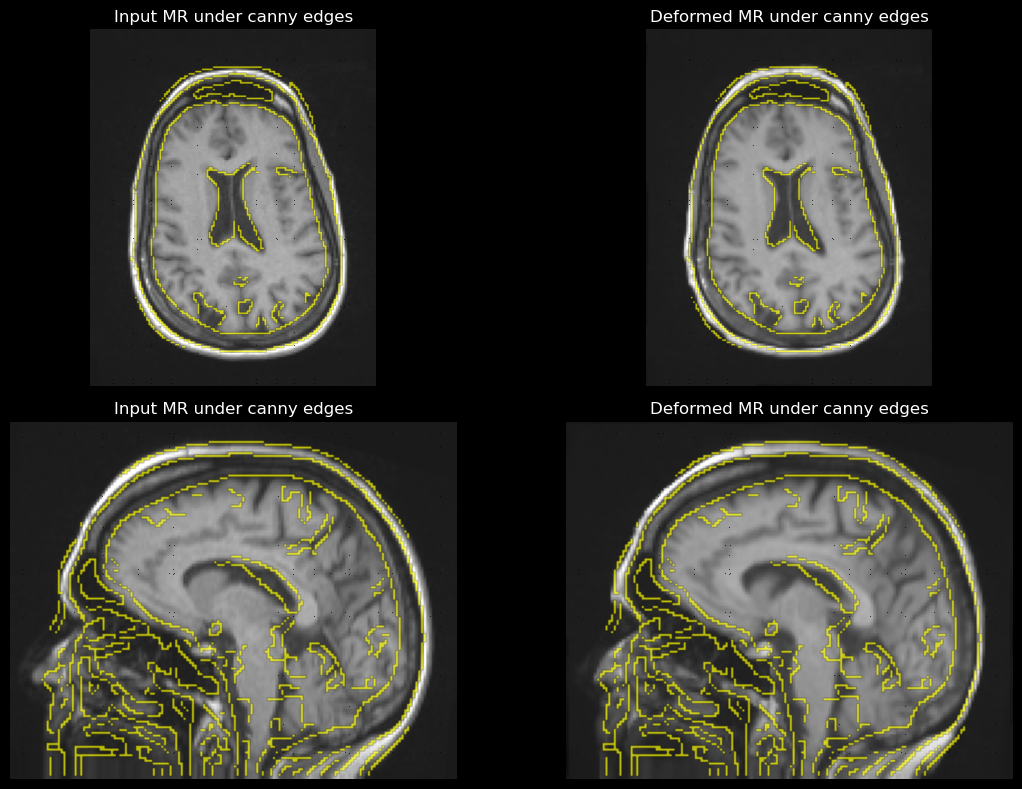

 50%|█████     | 5/10 [00:52<00:51, 10.36s/it]

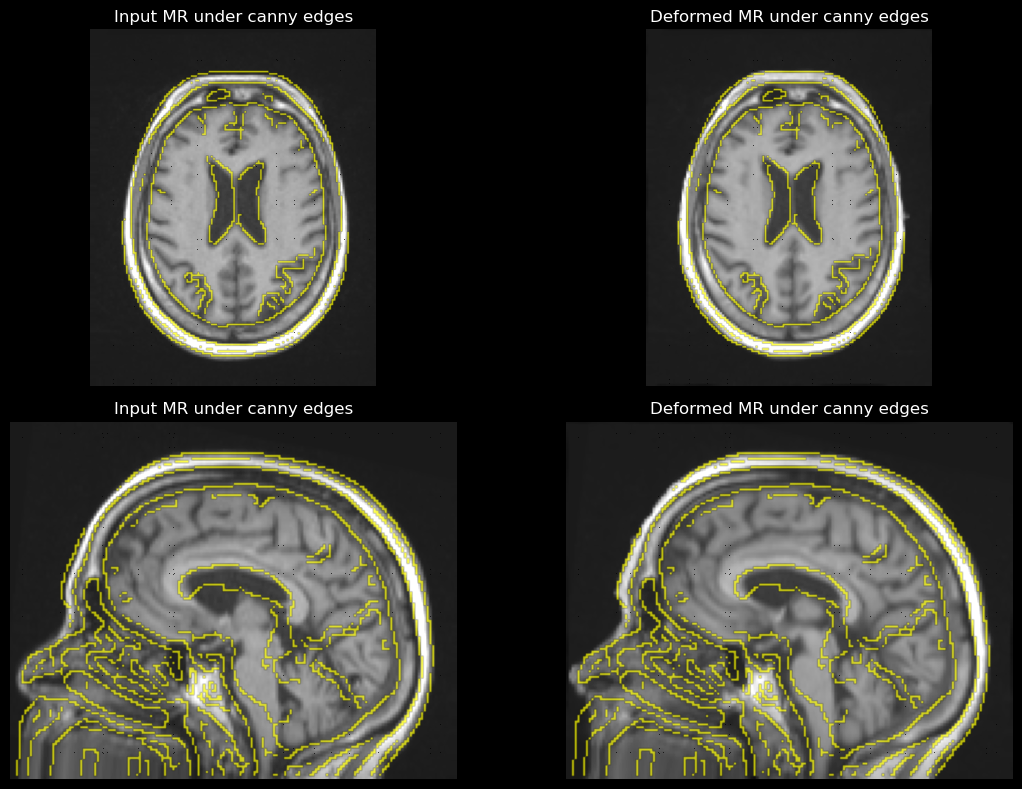

 60%|██████    | 6/10 [01:02<00:41, 10.28s/it]

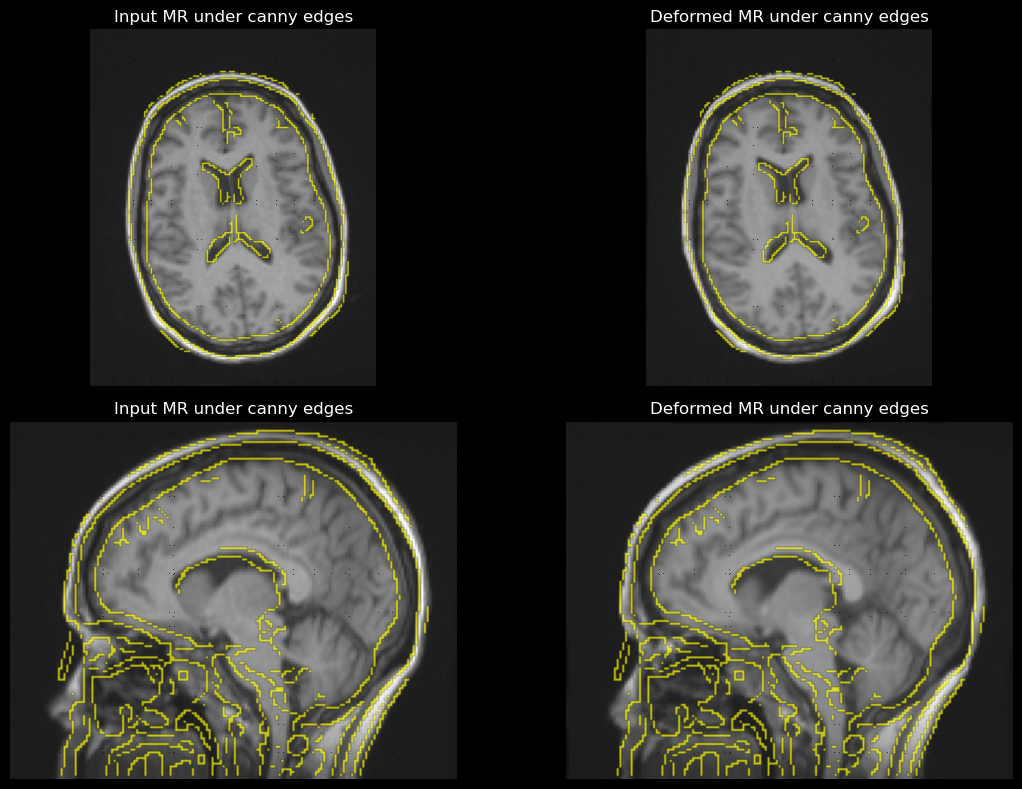

 70%|███████   | 7/10 [01:12<00:30, 10.26s/it]

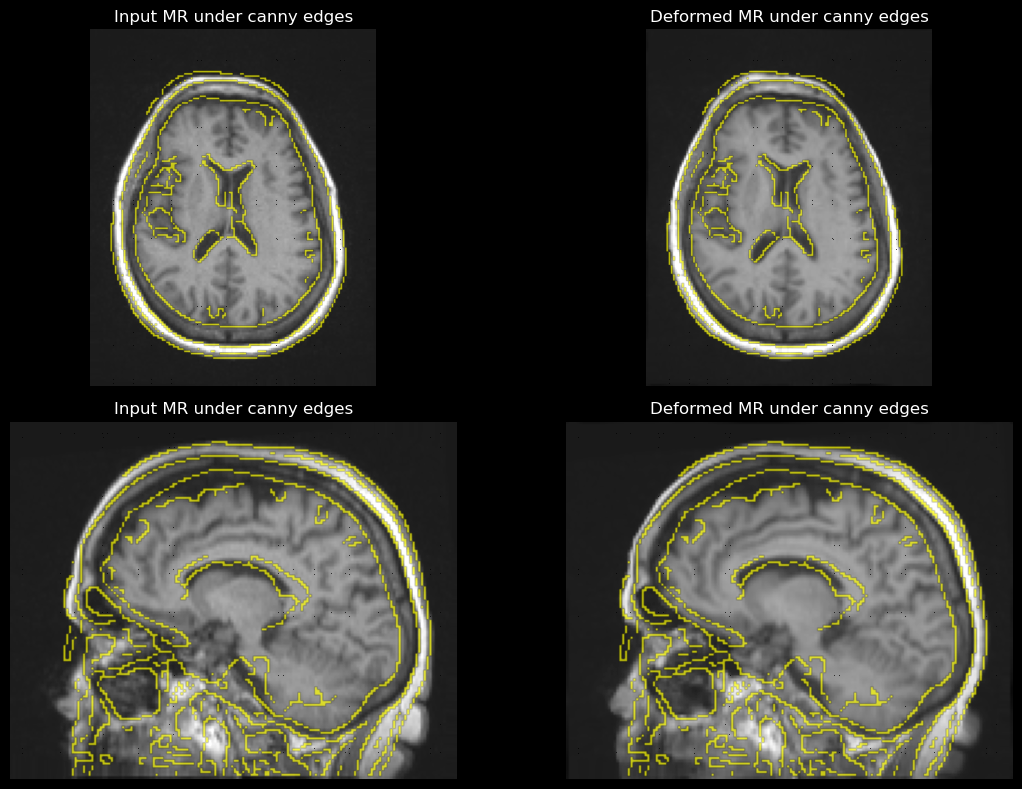

 80%|████████  | 8/10 [01:23<00:20, 10.34s/it]

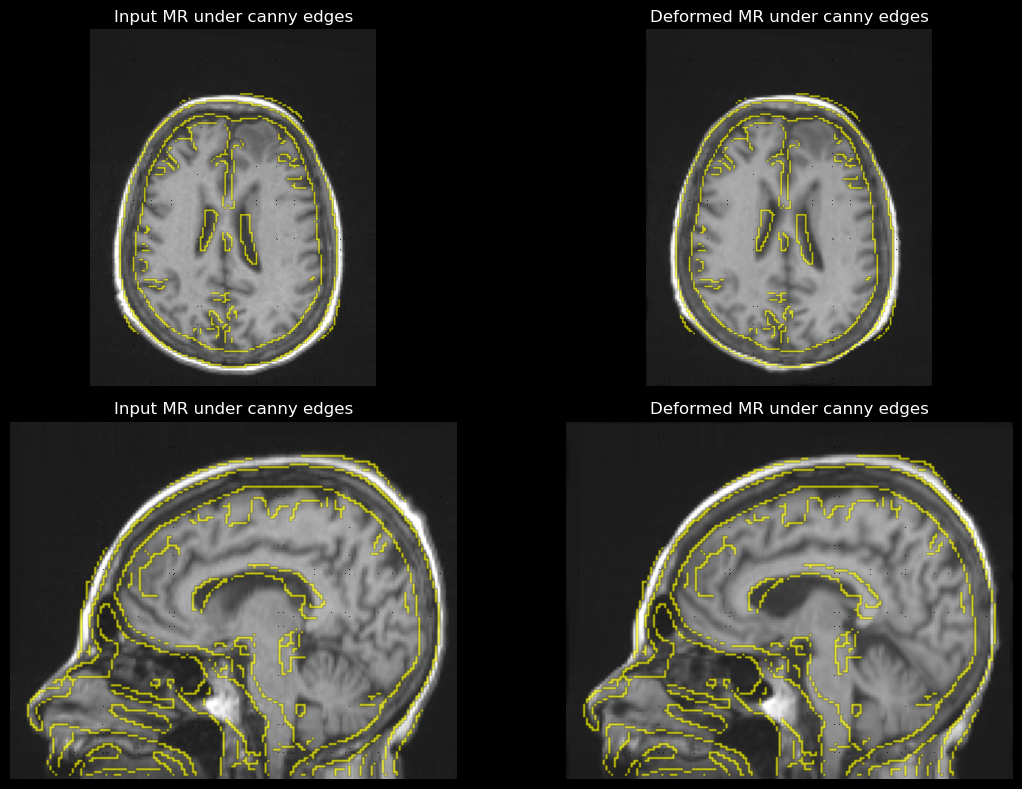

 90%|█████████ | 9/10 [01:33<00:10, 10.39s/it]

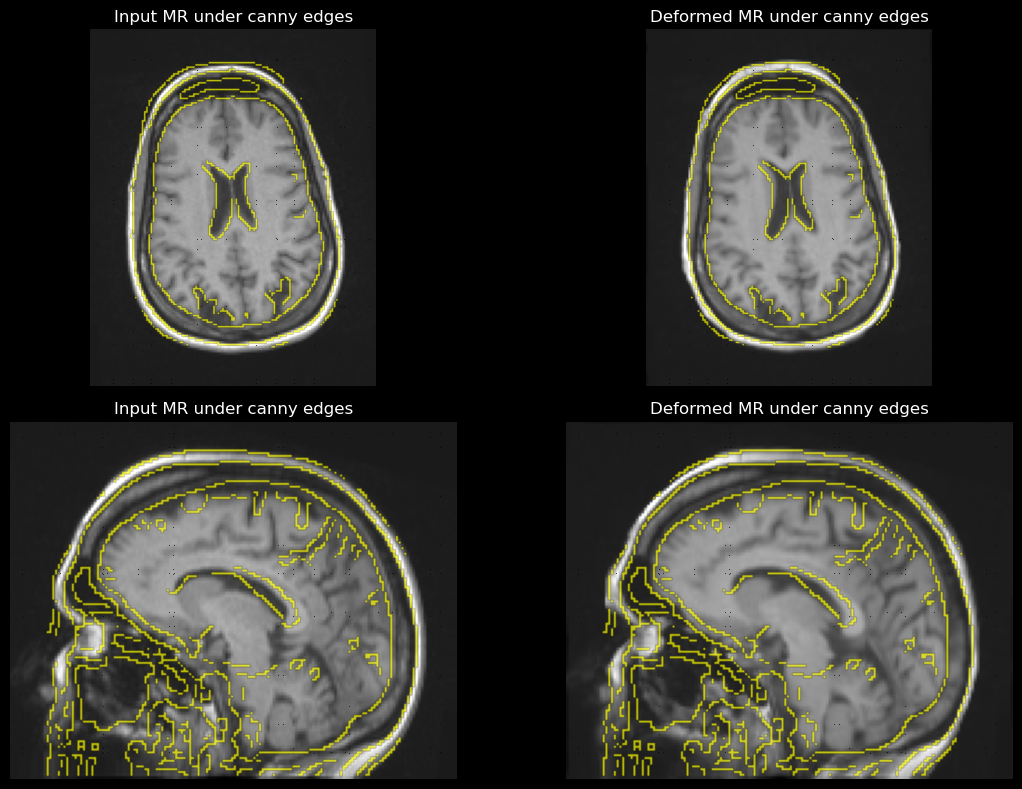

100%|██████████| 10/10 [01:44<00:00, 10.42s/it]


In [64]:
from tqdm import tqdm
import networks_gan
from layers import SpatialTransformer
from skimage.feature import canny
from matplotlib import colors as mplcolors
from helpers import compute_surface_metrics, compute_TRE
import losses

def colormap_binary(fg, bg=(0,0,0), alpha=None):
    fg = mplcolors.to_rgb(fg)
    bg = mplcolors.to_rgb(bg)
    cmap = mplcolors.LinearSegmentedColormap.from_list('Binary', (bg,fg), 256)
    if alpha is not None:
        cmap._init()
        cmap._lut[:,-1] = np.linspace(0, alpha, cmap.N+3)
    return cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')

metrics = pd.DataFrame()
mask_val = [1,2,23,5,19,29,8]

for ep in range(1):
    G.load_state_dict(checkpoint['G_state_dict'])
    dice_before_total = []
    dice_after_total = []
    hd_before_total = []
    sd_before_total = []
    hd_after_total = []
    
    sd_after_total = []
    tre_before_total = []
    tre_after_total = []
    
    for i in tqdm(range(10)):
        # cbct_fixed = cbct_input[i].float().to(device)
        # mr_moving = mr_input[i].float().to(device)
        # seg_fixed =mask_gt[i].float().to(device)
        # seg_moving = mask_input[i].float().to(device)
        # ct_fixed = ct_gt[i].float().to(device)
        
        cbct_fixed = torch.from_numpy(cbct_input[i]).float().to(device)
        mr_moving = torch.from_numpy(mr_input[i]).float().to(device)
        seg_fixed =torch.from_numpy(mask_gt[i]).float().to(device)
        seg_moving = torch.from_numpy(mask_input[i]).float().to(device)
        ct_fixed = torch.from_numpy(ct_gt[i]).float().to(device)
        
        mr_moving = mr_moving.unsqueeze(0).unsqueeze(0)
        cbct_fixed = cbct_fixed.unsqueeze(0).unsqueeze(0)
        seg_moving = seg_moving.unsqueeze(0).unsqueeze(0)
        seg_fixed = seg_fixed.unsqueeze(0).unsqueeze(0)
        
        for val in [6, 20, 24, 30, 9]:
            seg_fixed[seg_fixed == val] -= 1
            seg_moving[seg_moving == val] -= 1
        mask_fixed = torch.cat([seg_fixed == val for val in mask_val], dim=1)
        mask_moving = torch.cat([seg_moving == val for val in mask_val], dim=1)
        
        seg_fixed = mask_fixed.float()
        seg_moving = mask_moving.float()
     
        islice = 72
        islice_s = 68
        with torch.no_grad():
            flow, ct_moving_synth, ct_fixed_synth= G(mr_moving, cbct_fixed)
            
            mr_reg = SpatialTransformer([128,160,128], mode='bilinear').to(device)(mr_moving, flow[0])
            ct_reg_synth = SpatialTransformer([128,160,128], mode='bilinear').to(device)(ct_moving_synth[0], flow[0])
            seg_reg =SpatialTransformer([128,160,128], mode='nearest').to(device)(seg_moving, flow[0])
            
            fig, ax = plt.subplots(2,2,figsize=(12,8))
            np.vectorize(lambda ax: ax.axis('off'))(ax)
            
            ax[0, 0].imshow(mr_moving[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
            ax[0, 0].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            ax[0, 0].set_title('Input MR under canny edges')
            
            ax[0, 1].imshow(mr_reg[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
            ax[0, 1].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            ax[0, 1].set_title('Deformed MR under canny edges')
            
            ax[1, 0].imshow(torch.flipud(mr_moving[0,0,islice_s,:,:].T), cmap='gray', vmin=0, vmax=0.4)
            ax[1, 0].imshow(np.flipud(canny(ct_fixed.cpu().numpy()[islice,:,:].T, sigma=1)), cmap=colormap_binary('yellow', alpha=0.7))
            ax[1, 0].set_title('Input MR under canny edges')
            
            ax[1, 1].imshow(torch.flipud(mr_reg[0,0,islice_s,:,:].T), cmap='gray', vmin=0, vmax=0.4)
            ax[1, 1].imshow(np.flipud(canny(ct_fixed.cpu().numpy()[islice,:,:].T, sigma=1)), cmap=colormap_binary('yellow', alpha=0.7))
            ax[1, 1].set_title('Deformed MR under canny edges')     

            plt.tight_layout()
            plt.show()
            
            dice_before = []
            hd_before = []
            sd_before = []
            dice_after= []
            hd_after = []
            sd_after = []
            for j, val in enumerate(mask_val):
                mask_fixed = seg_fixed[:,j:j+1,:,:,:]
                mask_moving = seg_moving[:,j:j+1,:,:,:]
                mask_registered = seg_reg[:,j:j+1,:,:,:]
                dice_before.append(-losses.Dice().loss(mask_fixed,mask_moving).item())
                dice_after.append(-losses.Dice().loss(mask_fixed,mask_registered).item())
                metrics_before = compute_surface_metrics(np.squeeze(mask_fixed.squeeze().cpu().numpy())==1, np.squeeze(mask_moving.squeeze().cpu().numpy())==1)
                metrics_after = compute_surface_metrics(np.squeeze(mask_fixed.squeeze().cpu().numpy())==1, np.squeeze(mask_registered.squeeze().cpu().numpy())==1)
                hd_before.append(metrics_before['hd'])
                hd_after.append(metrics_after['hd'])
                sd_before.append(metrics_before['avg_dist'])
                sd_after.append(metrics_after['avg_dist'])
                
            # valid_ds = np.load(glob.glob(os.path.join("/mnt/blackhole-data2/RadOnc_Brain/Validation",'*.npz'))[i])
            # seg_fixed = valid_ds['ventricle_fixed']
            # seg_moving = valid_ds['ventricle_moving']
            # seg_fixed = torch.from_numpy(resize(seg_fixed, [128,160,128], order=0, anti_aliasing=False)).unsqueeze(0).unsqueeze(0).to(device)
            # seg_moving = torch.from_numpy(resize(seg_moving, [128,160,128], order=0, anti_aliasing=False)).unsqueeze(0).unsqueeze(0).to(device)
            # seg_reg = vxm.layers.SpatialTransformer([128,160,128], mode='nearest').to(device)(seg_moving, flow[0])
            # tre_before_total.append(compute_TRE(seg_fixed.squeeze().cpu().numpy(), seg_moving.squeeze().cpu().numpy(), [1,1,1]).mean())
            # tre_after_total.append(compute_TRE(seg_fixed.squeeze().cpu().numpy(), seg_reg.squeeze().cpu().numpy(), [1,1,1]).mean())
            
            # print(dice_before.mean(),hd_before.mean(),sd_before.mean())
            # print(dice_after.mean(),hd_after.mean(),sd_after.mean())
            
            dice_before_total.append(dice_before)
            dice_after_total.append(dice_after)
            hd_before_total.append(hd_before)
            hd_after_total.append(hd_after)
            sd_before_total.append(sd_before)
            sd_after_total.append(sd_after)
    if ep == 0:
        d0 = {'Dice':np.reshape(np.array(dice_before_total),-1), 'HD':np.reshape(np.array(hd_before_total),-1), 'SD':np.reshape(np.array(sd_before_total),-1), 
              'anatomy':['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']*10, 'ep':[0]*70, 'method':['Rigid']*70}
        d0 = pd.DataFrame(data=d0)
        metrics = pd.concat([metrics, d0])

    d = {'Dice':np.reshape(np.array(dice_after_total),-1), 'HD':np.reshape(np.array(hd_after_total),-1), 'SD':np.reshape(np.array(sd_after_total),-1), 
         'anatomy':['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']*10, 'ep':[29+ep*10]*70, 'method':['JSR-Cascade']*70}
    d = pd.DataFrame(data=d)
    metrics = pd.concat([metrics, d])
            

   

In [65]:
sum_dice = 0
sum_hd = 0
sum_sd = 0
for name in ['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']:
    data = metrics[metrics['anatomy']==name]
    data = data[data['method']=='JSR-Cascade']
    sum_dice += data['Dice'].mean()
    sum_hd += data['HD'].mean()
    sum_sd += data['SD'].mean()
    Dice = data['Dice'].mean()
    
    HD = data['HD'].mean()
    SD = data['SD'].mean()
    print(name, Dice, HD, SD)

3rd Ventricle 0.5667347490787507 2.6244938916026705 0.5546667312598947
4th Ventricle 0.637987008690834 2.863969824444088 0.4725244939143788
Lateral Ventricles 0.7563061356544495 4.819546445009101 0.6234240318851437
Amygdala 0.7188738822937012 2.4527176973246747 0.35772053138635446
Hippocampus 0.6956944286823272 3.070939929361791 0.4472210606467354
Thalamus 0.803684413433075 3.4591303121969 0.5734606530715853
Caudate 0.5852453202009201 4.214612471400195 0.684056946420673


In [66]:
sum_dice = 0
sum_hd = 0
sum_sd = 0
for name in ['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']:
    data = metrics[metrics['anatomy']==name]
    data = data[data['method']=='Rigid']
    sum_dice += data['Dice'].mean()
    sum_hd += data['HD'].mean()
    sum_sd += data['SD'].mean()
    Dice = data['Dice'].mean()
    
    HD = data['HD'].mean()
    SD = data['SD'].mean()
    print(name, Dice, HD, SD)

3rd Ventricle 0.5851435571908951 2.5960964789923153 0.540218994230079
4th Ventricle 0.6682807713747024 2.9074265861256685 0.4318437634039335
Lateral Ventricles 0.8060253500938416 4.427803547662994 0.47435092717591665
Amygdala 0.7168105244636536 2.359965102585731 0.36561021924147685
Hippocampus 0.6924001306295395 2.7106345051267082 0.4599098185710007
Thalamus 0.8055332362651825 3.152445446778081 0.5750959911816638
Caudate 0.6446336209774017 3.5915517986669165 0.5415431370116385


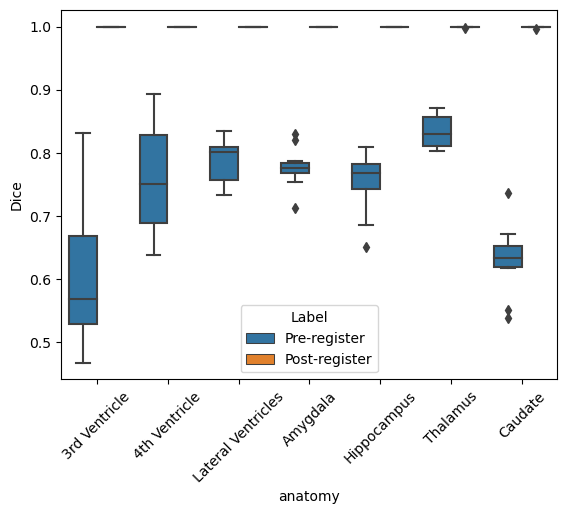

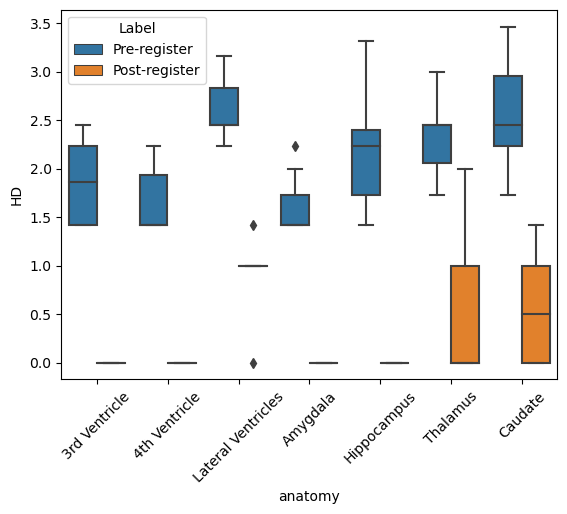

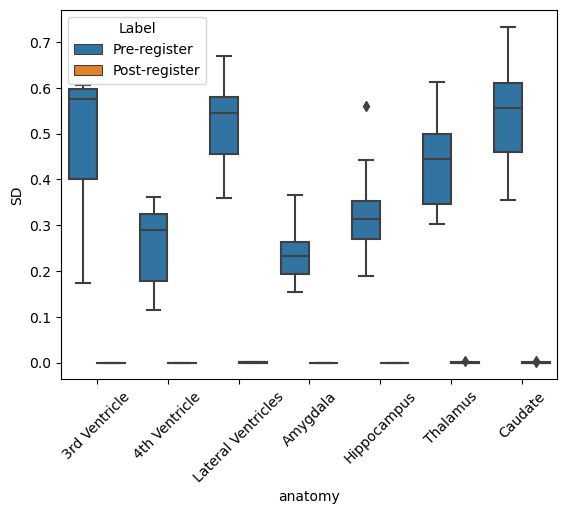

In [42]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
data1 = metrics[metrics['method']=='JSR-Cascade']
data2 = metrics[metrics['method']=='Rigid']
# data2 = pd.read_csv('lastlayers_seg.csv')
# data4 = pd.read_csv('lastlayers_sim.csv')

organs = ['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']
# List of evaluation metrics
metricses = ['Dice', 'HD', 'SD']
plt.style.use('default')
    
# Create box plots for each metric
for i,metric in enumerate(metricses):
    cdf = pd.concat(objs=[data1[metric],data2[[metric,'anatomy']]],axis=1) #],data3[metric],data4[[metric,
    cdf.columns = ['Pre-register','Post-register','anatomy']
    mdf = pd.melt(cdf, id_vars=['anatomy'], var_name='Label',value_name=metric)
    axs = sns.boxplot(x="anatomy", y=metric, hue="Label", data=mdf)    
    axs.set_xticklabels(axs.get_xticklabels(), rotation=45)
    plt.show()

In [44]:
from scipy import stats
def ttest(group1,group2,name):
    _, norm1 = stats.shapiro(group1)
    _, norm2 = stats.shapiro(group2)
    if norm1 <0.1 or norm2<0.1:
        _,p_value = stats.mannwhitneyu(group1, group2)
        if p_value < 0.05:
            print('There is significant difference in '+name)
        else:
            print('There is no significant difference in '+name)
    else:
        _, var = stats.levene(group1,group2)
        if var> 0.1:
            _, p_value = stats.ttest_ind(group1, group2)
            if p_value < 0.1:
                print('There is significant difference in '+name)
            else:
                print('There is no significant difference in '+name)
        else: 
            _, p_value = stats.ttest_ind(group1, group2, equal_var=False)
            if p_value < 0.1:
                print('There is significant difference in '+name)
            else:
                print('There is no significant difference in '+name)

In [45]:
for organ in organs:
    print('For '+organ)
    d1 = data1[data1['anatomy']==organ]
    d2 = data2[data2['anatomy']==organ]
    # d3 = data3[data3['anatomy']==organ]
    # d4 = data4[data4['anatomy']==organ]
    for metric in metricses:
        fd = d1[metric]
        sd = d2[metric]
        # td = d3[metric]
        # ed = d4[metric]
        ttest(fd,sd,metric)
        # print('For Conv:')
        # ttest(fd,td,metric)
        # print('For Sim:')
        # ttest(fd,ed,metric)

For 3rd Ventricle
There is significant difference in Dice
There is significant difference in HD
There is significant difference in SD
For 4th Ventricle
There is significant difference in Dice
There is significant difference in HD
There is significant difference in SD
For Lateral Ventricles
There is significant difference in Dice
There is significant difference in HD
There is significant difference in SD
For Amygdala
There is significant difference in Dice
There is significant difference in HD
There is significant difference in SD
For Hippocampus
There is significant difference in Dice
There is significant difference in HD
There is significant difference in SD
For Thalamus
There is significant difference in Dice
There is significant difference in HD
There is significant difference in SD
For Caudate
There is significant difference in Dice
There is significant difference in HD
There is significant difference in SD


/home/myi16/anaconda3/envs/jsr_Y/lib/python3.9/site-packages/scipy/stats/morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [60]:
meand = metrics[metrics['method']=='JSR-Cascade']
meand.mean()

/tmp/ipykernel_33628/1716046569.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  meand.mean()


Dice     0.732256
HD       2.533506
SD       0.408499
ep      29.000000
dtype: float64

In [61]:
meand = metrics[metrics['method']=='Rigid']
meand.mean()

/tmp/ipykernel_33628/3042583127.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  meand.mean()


Dice    0.913025
HD      1.525154
SD      0.100156
ep      0.000000
dtype: float64

/tmp/ipykernel_7411/1728390880.py:12: RuntimeWarning: divide by zero encountered in true_divide
  z = alpha*fix(1/((64-x)**2)**beta/2+1e-6)


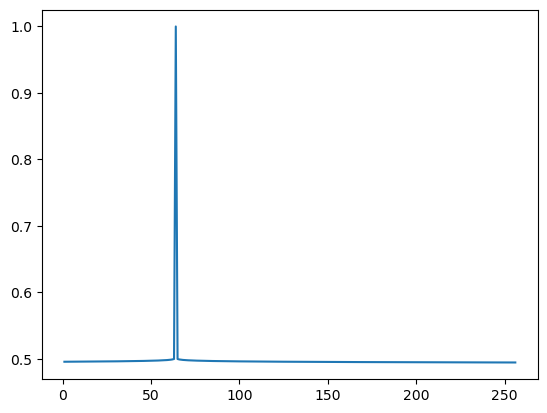

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def fix(y):
    y[~np.isfinite(y)] = 1
    return y

alpha = 1
beta = 0.001

x = np.linspace(1,256,256)
z = alpha*fix(1/((64-x)**2)**beta/2+1e-6)
# z = 5*(1-norm((64-x)**2))**2.2
plt.plot(x,z)
# plt.plot(x, np.exp(z))




In [18]:
z[64]

1.0